Selected features with Pearson Correlation: ['Toronto ED', 'SouthWest ED', 'Ontario ED', 'Essa PD', 'Ottawa PD', 'Essa ED', 'Weekly Highest Minimum Demand  Ontario', 'Ontario PD', 'Ottawa ED', 'West ED']


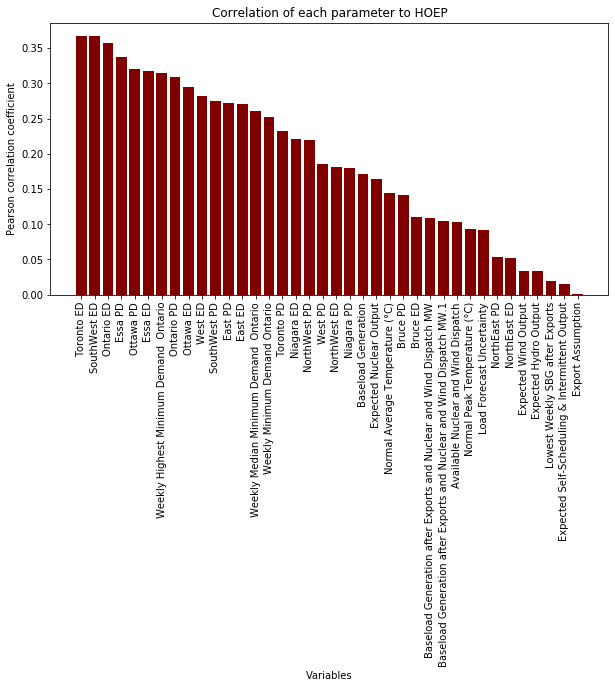

Selected features with MI: ['Expected Hydro Output', 'Normal Peak Temperature (°C)', 'Expected Wind Output', 'Available Nuclear and Wind Dispatch', 'SouthWest PD', 'Export Assumption', 'Ontario ED', 'Niagara ED', 'Essa PD', 'Ottawa PD']


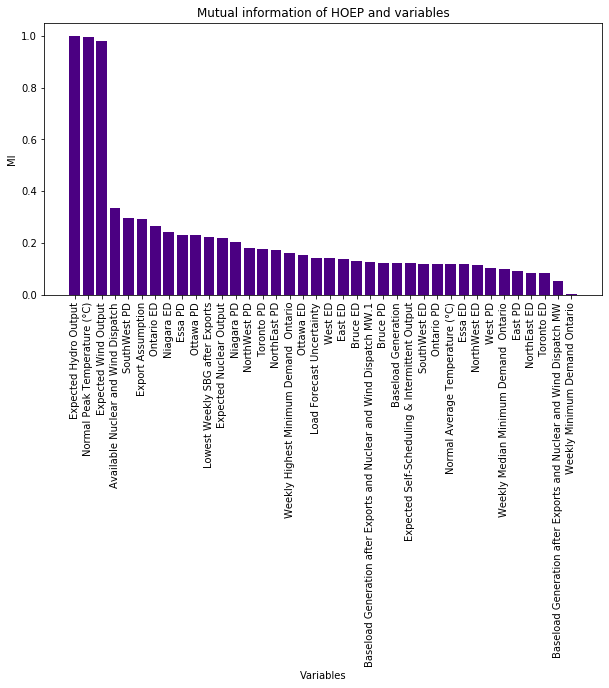

Selected features with Lasso: ['Bruce PD' 'NorthEast PD' 'NorthWest PD' 'Load Forecast Uncertainty'
 'Essa ED' 'NorthEast ED' 'SouthWest ED' 'Toronto ED'
 'Baseload Generation after Exports and Nuclear and Wind Dispatch MW.1'
 'Lowest Weekly SBG after Exports']
 
Number of selected features:  24
Selected features:
['Toronto ED', 'SouthWest ED', 'Ontario ED', 'Essa PD', 'Ottawa PD', 'Essa ED', 'Weekly Highest Minimum Demand  Ontario', 'Ontario PD', 'Ottawa ED', 'West ED', 'Expected Hydro Output', 'Normal Peak Temperature (°C)', 'Expected Wind Output', 'Available Nuclear and Wind Dispatch', 'SouthWest PD', 'Export Assumption', 'Niagara ED', 'Bruce PD', 'NorthEast PD', 'NorthWest PD', 'Load Forecast Uncertainty', 'NorthEast ED', 'Baseload Generation after Exports and Nuclear and Wind Dispatch MW.1', 'Lowest Weekly SBG after Exports']
 

rMSE for validation set:
Linear regression rMSE: 7.947844114008142
Lasso rMSE for validation set: 7.977928202429075


/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Elastic net rMSE: 7.932837748865415
Gradient Boosting rMSE on validation set: 5.1846


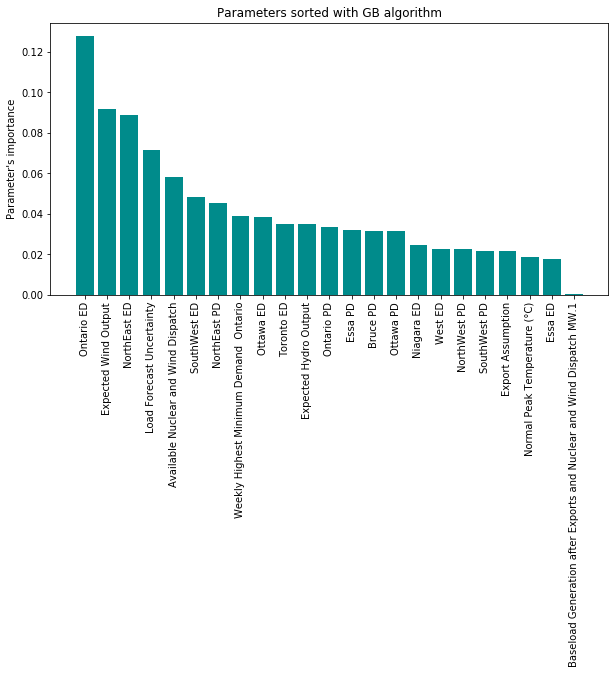

MLP rMSE: 8.9153
Test is done!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr
import glob
import operator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn import datasets, ensemble
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


# Parameters
path = "Data_18months_Outlook/*/*.xlsx"
glob.glob(path)

K_corr = 10 # Number of selected features with correlation
K_mi = 10 # Number of features selected with MI
printFeat = True
plotFig = True
N_train = 19


## Ascending format
#ascending_order = list([18,5,8,17,6,10,3,4,15,1,21,11,20,16,19,2,14,13,12,7,0,9])
#ascend_list = [glob.glob(path)[i] for i in ascending_order]
#my_list = ascend_list

train_test_order = list([18,8,17,6,10,3,4,15,1,21,11,16,2,14,13,12,7,0,9, 5,19,20])
my_list = [glob.glob(path)[i] for i in train_test_order]


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
#                                    TRAINING
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------

train_data = pd.DataFrame()
for f in my_list[0:N_train]:
    df = pd.read_excel(f)
    train_data = train_data.append(df,ignore_index=True)
# Converting datetime
train_data['Date (week ending)'] = pd.to_datetime(train_data['Date (week ending)'])


## ----------------------------------------------------
# Drop rows with missing values in selected columns
## ----------------------------------------------------
# train data
df = train_data.dropna(axis = 0, how='any', subset=['HOEP'])
df = df.dropna(axis = 0, how='any', subset=['Baseload Generation'])

# --------------------------------
# Pearson Correlation analysis
# -------------------------------
corr_list = []
hoep = df['HOEP']
columns_name = df.columns.ravel()

for i in columns_name[2:-2]:       # last two feature which are almost always zero are not included in the correlation to prevent warning for the code
    param = df[i]
    nans = np.isnan(np.array(param))
    corr, _ = pearsonr(hoep[~nans], param[~nans])
    corr_list.append(np.abs(corr))

corr_dictionary = dict(zip(columns_name[2:-2], corr_list))
sorted_corr = {k: v for k, v in sorted(corr_dictionary.items(), key=lambda item: item[1], reverse=True)}
corr_ind_dictionary = dict(zip(np.add(range(len(columns_name)-2),2), corr_list))
sorted_ind_corr = {k: v for k, v in sorted(corr_dictionary.items(), key=lambda item: item[1], reverse=True)}
inds_sorted = list(sorted_ind_corr.keys()) 

# Selected features with Correlation
sel_feat_corr = inds_sorted[0:K_corr]

if printFeat:    
    print('Selected features with Pearson Correlation:', sel_feat_corr)

if plotFig:
    # Plot the correlations
    keys = list(sorted_corr.keys()) 
    values = list(sorted_corr.values()) 
    fig = plt.figure(figsize = (10, 5)) 
    # creating the bar plot 
    plt.bar(keys, values, color ='maroon') 
    plt.xlabel("Variables") 
    plt.xticks(rotation=90)
    plt.ylabel("Pearson correlation coefficient") 
    plt.title("Correlation of each parameter to HOEP") 
    plt.savefig('Result_files/Figures/Correlation.png',bbox_inches='tight')
    plt.show() 

# -------------------------------
# Mutual Information
# -------------------------------
keys = list(sorted_corr.keys()) 
X = np.array(df[0:][keys])
Y = df[0:]['HOEP']

mi = mutual_info_regression(X, Y)
mi /= np.max(mi)

ind_sort = np.argsort(-mi)
mi_dictionary = dict(zip(columns_name[2:-1], mi))
sorted_mi = {k: v for k, v in sorted(mi_dictionary.items(), key=lambda item: item[1], reverse=True)}
mi_ind_dictionary = dict(zip(np.add(range(len(columns_name)-2),2), mi))
sorted_ind_mi = {k: v for k, v in sorted(mi_dictionary.items(), key=lambda item: item[1], reverse=True)}
inds_sorted = list(sorted_ind_mi.keys()) 

# Selected features with MI
sel_feat_mi = inds_sorted[0:K_mi]
if printFeat:
    print('Selected features with MI:', sel_feat_mi)

if plotFig:
    # Plot the Modulation index
    keys = list(sorted_mi.keys()) 
    values = list(sorted_mi.values()) 
    fig = plt.figure(figsize = (10, 5)) 
    # creating the bar plot 
    plt.bar(keys, values, color ='indigo') 
    plt.xlabel("Variables") 
    plt.xticks(rotation=90)
    plt.ylabel("MI") 
    plt.title("Mutual information of HOEP and variables") 
    plt.savefig('Result_files/Figures/MI.png',bbox_inches='tight')
    plt.show() 
# --------------------------------------------------
# Feature selection using regularization with LASSO 
# --------------------------------------------------

# Train-val split
X_train_full, X_val_full, y_train, y_val = train_test_split(
    df.drop(labels=['HOEP'], axis=1),
    df['HOEP'],
    test_size=0.25,
    random_state=0)

X_train = X_train_full.drop(labels=['Date (week ending)'], axis=1)
X_val = X_val_full.drop(labels=['Date (week ending)'], axis=1)

columns_name = df.columns.ravel()
Features_name = columns_name[2:]

X_train = np.array(X_train)
X_val = np.array(X_val)

scaler = StandardScaler()
scaler.fit(X_train)

# here, again I will train a Lasso Linear regression and select
# the non zero features in one line.

# Regression task
sel_ = SelectFromModel(Lasso(alpha=.35))
sel_.fit(scaler.transform(X_train), y_train)

# make a list with the selected features and print the outputs
selected_feat = Features_name[(sel_.get_support())]
sel_feat_index = np.array(sel_.get_support())
sel_feat_lasso = Features_name[(sel_.get_support())]
if printFeat:
    print('Selected features with Lasso:', sel_feat_lasso)


# Concatenate selected features
sel_feat_concat = list(np.concatenate((sel_feat_corr, sel_feat_mi, sel_feat_lasso)))
sel_feat = []              # removing duplicates
[sel_feat.append(x) for x in sel_feat_concat if x not in sel_feat] 
print(' ')
print("Number of selected features: ", len(sel_feat))
print('Selected features:')
print(sel_feat)
print(' \n')

# Transfer features to their index
sel_feat_ind = []
for feature in sel_feat:
    sel_feat_ind.append(list(columns_name[2:]).index(feature))

X_train = X_train[:,sel_feat_ind]
X_val = X_val[:,sel_feat_ind]

# --------------------------------
# Linear Regression
# -------------------------------

reg_lin=LinearRegression()
reg_lin.fit(X_train,y_train)
rmse_Linear=np.sqrt(mean_squared_error(y_true=y_val,y_pred=reg_lin.predict(X_val)))
print('rMSE for validation set:')
print('Linear regression rMSE:', rmse_Linear)


# -----------------------------
# Regression with Lasso
# -----------------------------
# Regression
reg_lasso = LassoCV(cv=5, random_state=0, max_iter = 30000).fit(X_train, y_train)
reg_lasso.score(X_train, y_train)
y_pred = reg_lasso.predict(X_val)
Lasso_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print('Lasso rMSE for validation set:',Lasso_rmse)

# ------------------------------------------
# Regression with Elastic Net (Both Ridge and Lasso)
# ------------------------------------------
elastic=ElasticNet(normalize=True, max_iter = 10000)

# Finding the best parameters for the model
search=GridSearchCV(estimator=elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)
search.fit(X_train,y_train)
parameters_n = search.best_params_
param_list = list(parameters_n.keys())

# set the parameters
elastic=ElasticNet(normalize=True,alpha=parameters_n[param_list[0]],l1_ratio=parameters_n[param_list[1]], max_iter = 30000)
elastic.fit(X_train,y_train)
elastic_rmse=np.sqrt(mean_squared_error(y_true=y_val,y_pred=elastic.predict(X_val)))
print('Elastic net rMSE:', elastic_rmse)

# --------------------------
# Gradient boosting
# -------------------------
# Gradient boosting with the hyper parameters that are set in a separate process

params = {'n_estimators': 600,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.06,
          'loss': 'ls'}
reg_gb = ensemble.GradientBoostingRegressor(**params)
reg_gb.fit(X_train, y_train)
gb_rmse = np.sqrt(mean_squared_error(y_val, reg_gb.predict(X_val)))
print("Gradient Boosting rMSE on validation set: {:.4f}".format(gb_rmse))

gb_fi = reg_gb.feature_importances_    # feature importance
ind_sort = np.argsort(-gb_fi)
gb_dictionary = dict(zip(sel_feat[0:-1], gb_fi))
sorted_gb = {k: v for k, v in sorted(gb_dictionary.items(), key=lambda item: item[1], reverse=True)}
gb_ind_dictionary = dict(zip(np.add(range(len(sel_feat)-2),2), gb_fi))
sorted_ind_gb = {k: v for k, v in sorted(gb_dictionary.items(), key=lambda item: item[1], reverse=True)}
inds_sorted = list(sorted_ind_gb.keys()) 

if plotFig:
    keys = list(sorted_gb.keys()) 
    values = list(sorted_gb.values()) 
    fig = plt.figure(figsize = (10, 5)) 
    # creating the bar plot 
    plt.bar(keys, values, color ='darkcyan') 
    #plt.xlabel("Variables") 
    plt.xticks(rotation=90)
    plt.ylabel("Parameter's importance") 
    plt.title("Parameters sorted with GB algorithm") 
    plt.savefig('Result_files/Figures/GB.png',bbox_inches='tight')
    plt.show() 

# --------------------------
# MLP
# -------------------------
reg_mlp = MLPRegressor(random_state=1,hidden_layer_sizes=(10,3), max_iter=10000,learning_rate_init=.001,activation='relu')
reg_mlp.fit(X_train, y_train)
y_pred = reg_mlp.predict(X_val)
#regr.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(y_val, reg_mlp.predict(X_val)))
print("MLP rMSE: {:.4f}".format(rmse))


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
#                                   FUNCTIONS
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------


# This function estimate monthly cost from weekly data with bringing them to daily system first    
def estimate_monthly_cost(weekly_HOEP, weekly_datetime):   
    weekly_dict = dict(zip(weekly_datetime, weekly_HOEP))    
    daily_dict = {}
    for key in weekly_dict:
        for days_to_subtract in range(7):
            new_key = key - timedelta(days=days_to_subtract)
            daily_dict.update({new_key: weekly_dict[key]})

    output_df = pd.DataFrame()
    output_df['Date'] = list(daily_dict.keys())
    output_df['Date'] = pd.to_datetime(output_df['Date'])
    output_df['HOEP'] = list(daily_dict.values())
    return output_df.groupby(output_df.Date.dt.to_period("M")).mean()


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
#                                    TESTING
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
Full_path = "Data_18months_Outlook/*/*.xlsx"

for i_test in range(3):
    
    test_data = pd.DataFrame()
    for f in  my_list[i_test+N_train:i_test+N_train+1]:
        df = pd.read_excel(f)
        test_data = test_data.append(df,ignore_index=True)
    
        test_data['Date (week ending)'] = pd.to_datetime(test_data['Date (week ending)'])

        # extracting the start of 18 month period
        String = ''.join(f)
        ind = String.find('.xlsx')
        Range_name = String[ind-8:ind]
        
        # test data
        df_test = test_data.dropna(axis = 0, how='any', subset=['East PD','Baseload Generation'])
        df_test.describe()
        
        X_test = df_test[columns_name[2:]] # Removing price and date
        X_test = np.array(X_test)
        scaler = StandardScaler()          # Scaling the data
        scaler.fit(X_test)

        X_test = X_test[:,sel_feat_ind]    # Extracting selected features

        # Gradient boosting
        pred_gb_test_df = estimate_monthly_cost(reg_gb.predict(X_test), df_test['Date (week ending)'])
        a = str('Result_files/'+str(Range_name)+'_gb_result.xlsx')
        pred_gb_test_df.to_excel(a)

        # Linear regression
        pred_other_test_df = estimate_monthly_cost(reg_lin.predict(X_test), df_test['Date (week ending)'])
        b = str('Result_files/'+str(Range_name)+'_lin_result.xlsx')
        pred_other_test_df.to_excel(b)

        # Lasso regression
        pred_other_test_df = estimate_monthly_cost(reg_lasso.predict(X_test), df_test['Date (week ending)'])
        b = str('Result_files/'+str(Range_name)+'_lasso_result.xlsx')
        pred_other_test_df.to_excel(b)

print('Test is done!')